In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from datetime import date,tzinfo
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 

In [2]:
dataset=pd.read_csv("Date&Transactionvalue.csv")

In [3]:
dataset

,Date,block,Transaction_value
0,2009-08-12,63,315000000000
1,2009-08-13,85,425000000000
2,2009-08-14,63,315000000000
3,2009-08-15,26,130000000000
4,2009-08-16,19,95000000000
...,...,...,...
4349,2021-07-09,733928,342560205304413
4350,2021-07-10,624905,185504058952898
4351,2021-07-11,549455,185854409979274
4352,2021-07-12,707519,167690416361542


In [4]:
data1=pd.read_csv("Transactions.csv")
data1

,Date,Transactions
0,2009-08-12,63
1,2009-08-13,85
2,2009-08-14,63
3,2009-08-15,26
4,2009-08-16,19
...,...,...
4349,2021-07-09,131
4350,2021-07-10,161
4351,2021-07-11,125
4352,2021-07-12,126


In [5]:
year =input("Please enter Initial year ")
yearf =input("Please enter final year ")
initial = int(year)
final = int(yearf)
#initial=int(initial_date)
#final=int(final_date)

Please enter Initial year 2019
Please enter final year 2020


In [18]:
result1 = pd.merge(data1,dataset,on='Date')
result1['Date'] = result1['Date'].astype('datetime64[ns]')
result2=result1.loc[result1['Date']<='01-08-2016']
result =result1.loc[(result1['Date'].dt.year>=initial) &(result1['Date'].dt.year<=final) ]
result

,Date,Transactions,block,Transaction_value
3429,2019-01-01,149,558327,54976665348468
3430,2019-01-02,151,657911,98571674337309
3431,2019-01-03,155,699373,94039796409401
3432,2019-01-04,149,693567,97245582287961
3433,2019-01-05,163,629683,76243509607456
...,...,...,...,...
4155,2020-12-27,148,879278,251461469764890
4156,2020-12-28,160,909933,198085200746056
4157,2020-12-29,152,982939,184594688181153
4158,2020-12-30,172,1021542,174350084672406


In [19]:
len(result2)

2341

In [20]:
result2.describe()


,Transactions,block,Transaction_value
count,2341.000000,2.341000e+03,2.341000e+03
mean,158.608714,1.301091e+05,1.066972e+14
std,40.755837,1.675877e+05,1.857716e+14
min,7.000000,7.000000e+00,3.500000e+10
25%,142.000000,4.414000e+03,1.977491e+13
50%,156.000000,8.136000e+04,7.015877e+13
75%,174.000000,2.051280e+05,1.259636e+14
max,692.000000,2.035035e+06,3.132587e+15


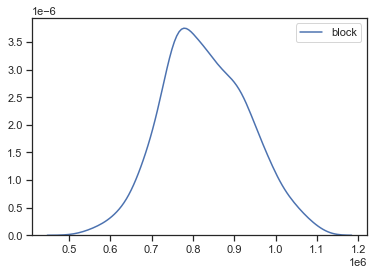

In [21]:
sns.kdeplot(result['block'])

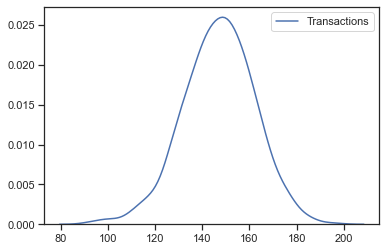

In [22]:
sns.kdeplot(result['Transactions'])

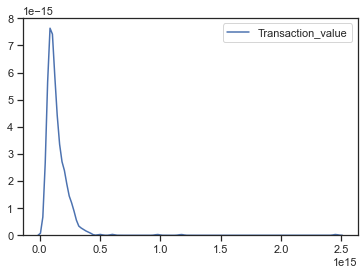

In [23]:
sns.kdeplot(result['Transaction_value'])

Text(0.5, 1.0, 'Transactions per year')

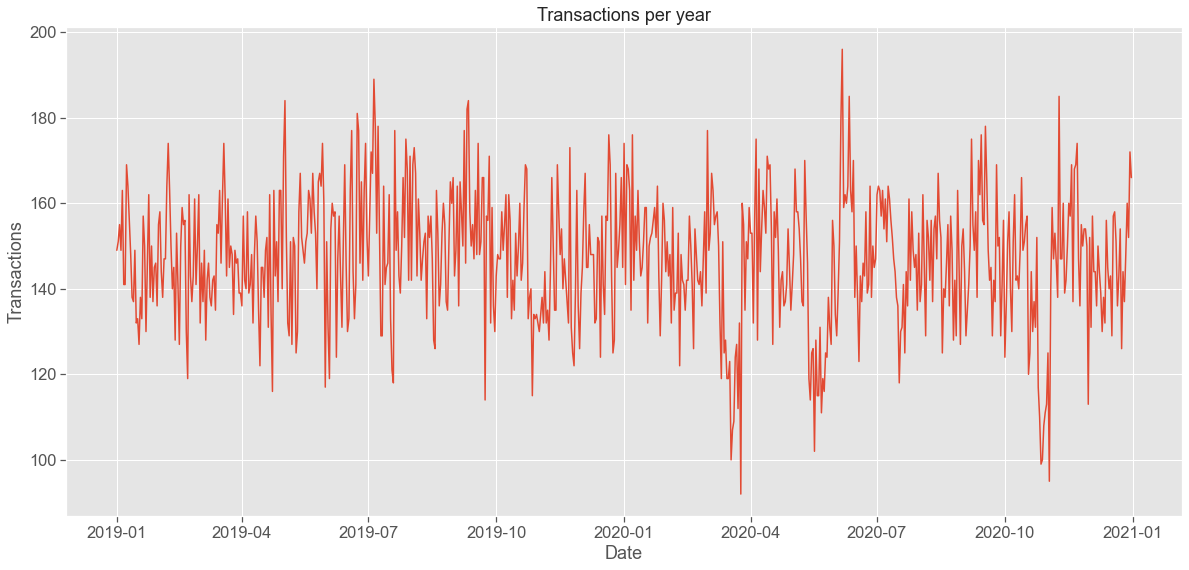

In [24]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Transactions', data=result, palette='Blues_d')
plt.title('Transactions per year')

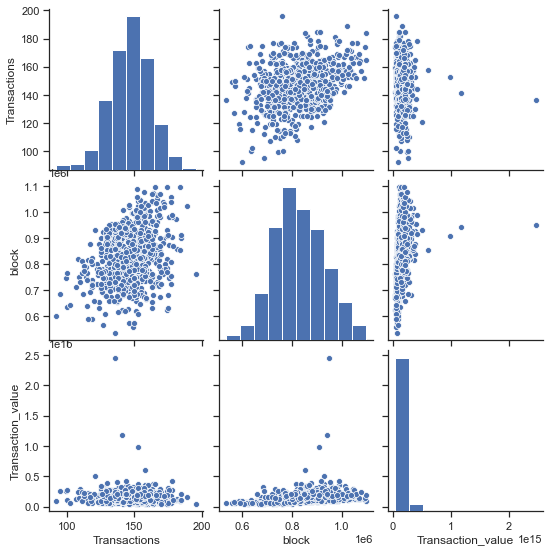

In [25]:
sns.set(style="ticks")
sns.pairplot(result)

In [26]:
#data2=result.loc[result['Date']>='2013-08-12']
data2 = result2[['Transaction_value','block','Transactions']]
data3 = result[['Transaction_value','block','Transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data2)
data2 = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data2)

IsolationForest(contamination=0.05)

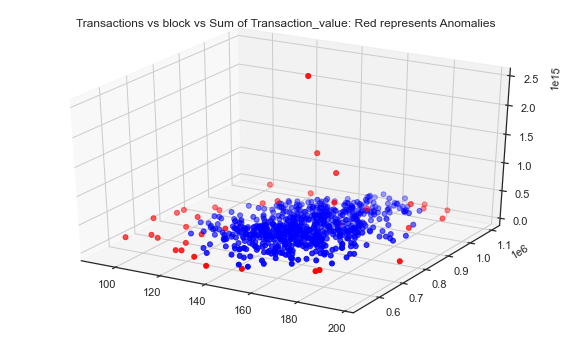

In [27]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111,projection='3d')
X = result.iloc[:,1:4].values
colors = np.array(['red', 'blue'])
y_pred = model.fit_predict(data3)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=25, color=colors[(y_pred + 1) // 2] )
#ax.legend()
#plt.xlabel('Transactions')
#plt.ylabel('Blocks')
#plt.zlabel('Sum of Output Satoshis')
plt.title('Transactions vs block vs Sum of Transaction_value: Red represents Anomalies')
plt.savefig('IsolationForest_anomaly.png', dpi=1000)

In [28]:
result['anomaly_IsolationForest'] = model.predict(data3)
result['anomaly_IsolationForest'] = result['anomaly_IsolationForest'].apply(lambda x: x == -1)
result['anomaly_IsolationForest'] = result['anomaly_IsolationForest'].astype(int)
result['anomaly_IsolationForest'].value_counts()

0    694
1     37
Name: anomaly_IsolationForest, dtype: int64

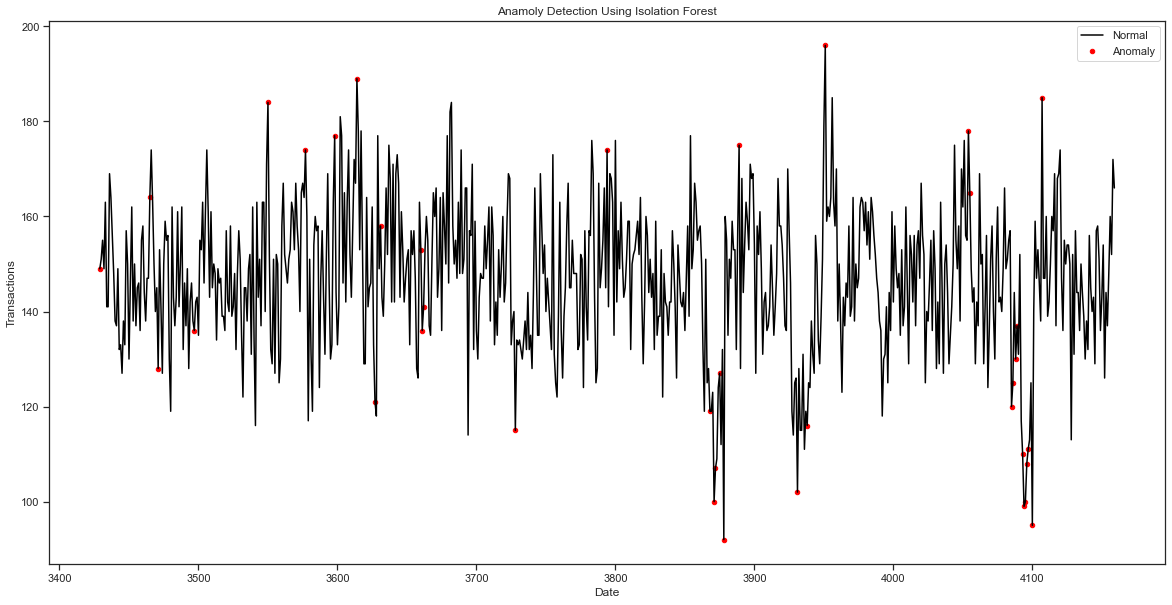

In [29]:
fig, ax = plt.subplots(figsize=(20,10))

#anomaly
a = result.loc[result['anomaly_IsolationForest'] == 1]
ax.plot(result['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=20)
plt.legend()
plt.title("Anamoly Detection Using Isolation Forest")
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.savefig('IsolationForest_anomaly_Transactions.png')
plt.show();

In [30]:
result.head(5)

,Date,Transactions,block,Transaction_value,anomaly_IsolationForest
3429,2019-01-01,149,558327,54976665348468,1
3430,2019-01-02,151,657911,98571674337309,0
3431,2019-01-03,155,699373,94039796409401,0
3432,2019-01-04,149,693567,97245582287961,0
3433,2019-01-05,163,629683,76243509607456,0


In [31]:
## the dates and the no of transactions found to be anamoly

In [32]:
final_anomaly = result.query('anomaly_IsolationForest == 1')
final_anomaly

,Date,Transactions,block,Transaction_value,anomaly_IsolationForest
3429,2019-01-01,149,558327,54976665348468,1
3465,2019-02-06,164,814730,367002074705545,1
3471,2019-02-12,128,682877,317662877211775,1
3497,2019-03-10,136,534516,66293708096304,1
3550,2019-05-02,184,1096850,98656356920911,1
3577,2019-05-29,174,1094814,142645261513318,1
3598,2019-06-19,177,1059323,167318262682240,1
3614,2019-07-05,189,1021693,156404498834670,1
3627,2019-07-18,121,929840,500935648131649,1
3631,2019-07-22,158,852999,603316890500615,1


In [33]:
##Applying KNN method

In [34]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [35]:
def pca_results(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

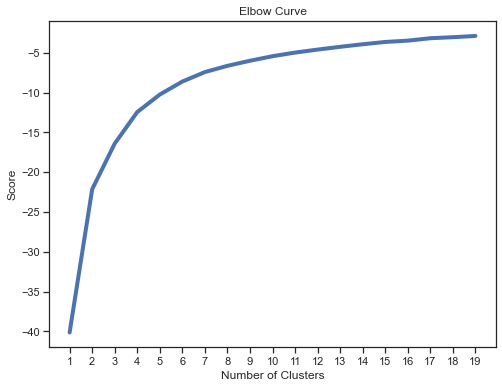

In [36]:
data_ = data3.copy() # make a copy of data with three already selected features
data_ = data_.reset_index(drop=True)
data_[:] = MinMaxScaler().fit_transform(data_[:])
pca = PCA(n_components=2) # we have selected 2 components in PCA for simplicity
pca.fit(data_)
reduced_data = pca.transform(data_)
reduced_data = pd.DataFrame(reduced_data)

num_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i).fit(reduced_data) for i in num_clusters]
scores = [kmeans[i].score(reduced_data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(num_clusters, scores, linewidth = 4)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

,Explained Variance,Transaction_value,block,Transactions
Dimension 1,0.6633,-0.0650,-0.8870,-0.4572
Dimension 2,0.2976,-0.1109,-0.4489,0.8867


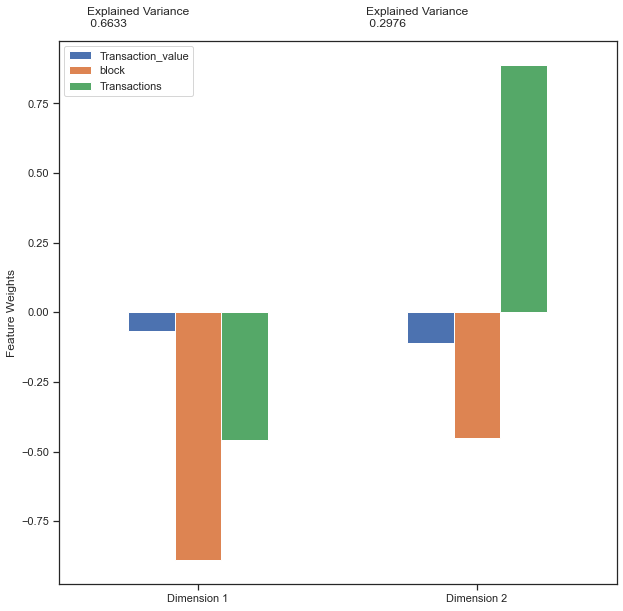

In [37]:
correlations = pd.DataFrame(data=data_).corr()
pca_results(correlations, pca)

In [38]:
best_num_cluster__ = 3
km__ = KMeans(n_clusters=best_num_cluster__)
km__.fit(reduced_data)
km__.predict(reduced_data)
labels__1 = km__.labels_

#Choosing the four clusters based on the elbow curve
best_num_cluster = 4
km = KMeans(n_clusters=best_num_cluster)
km.fit(reduced_data)
km.predict(reduced_data)
labels = km.labels_

#Choosing the five clusters based on the elbow curve
best_num_cluster_ = 5
km_ = KMeans(n_clusters=best_num_cluster_)
km_.fit(reduced_data)
km_.predict(reduced_data)
labels_1 = km_.labels_

Text(0.5, 1.0, 'Clusters based on K means: 3 clusters')

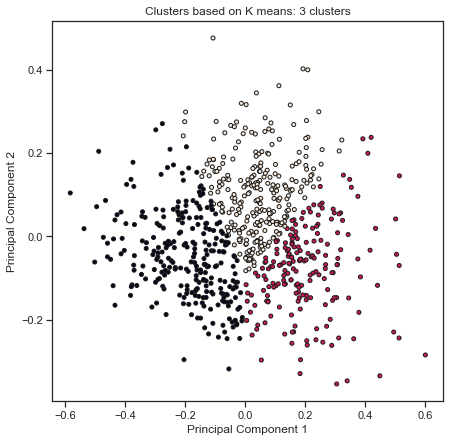

In [39]:
#Plotting based on three cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels__1.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 3 clusters')

Text(0.5, 1.0, 'Clusters based on K means: 4 clusters')

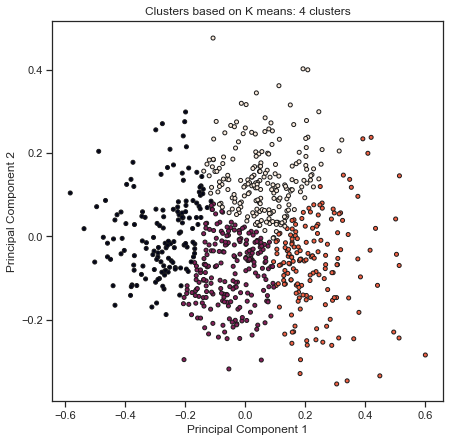

In [40]:
#Plotting based on four cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 4 clusters')

Text(0.5, 1.0, 'Clusters based on K means: 5 clusters')

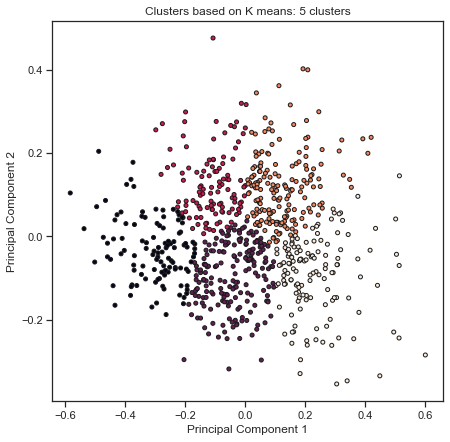

In [41]:
#Plotting based on five cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels_1.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 5 clusters')

In [42]:
reduced_data.loc[0]
mod = kmeans[best_num_cluster-1]
mod.cluster_centers_

array([[ 0.23463208, -0.06657706],
       [ 0.05803484,  0.13720386],
       [-0.04852311, -0.0870564 ],
       [-0.27834668,  0.01215043]])

In [43]:
reduced_data['Principal Component 1'] = reduced_data[0]
reduced_data['Principal Component 2'] = reduced_data[1]
reduced_data.drop(columns = [0, 1], inplace=True)
reduced_data.head()

,Principal Component 1,Principal Component 2
0,0.421057,0.237539
1,0.254013,0.173084
2,0.171151,0.174295
3,0.206600,0.127629
4,0.246384,0.298954


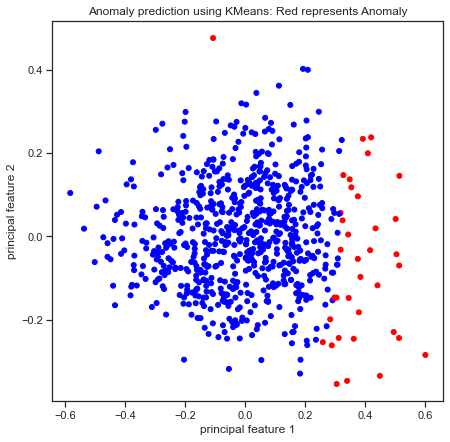

In [44]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.05
# find the distance between each point and its nearest centroid. The largest distances will be consdiered anomalies
distance = getDistanceByPoint(reduced_data, kmeans[best_num_cluster-1])
distance = pd.Series(distance)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()


# anomaly_kmeans contain the anomaly result of the above method  (0:normal, 1:anomaly) 
data_['anomaly_kmeans'] = (distance >= threshold).astype(int)
# visualisation of anomaly with cluster view
#fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
#colors = {1:'#f70505', 0:'#0a48f5'}
plt.figure(figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=data_["anomaly_kmeans"].apply(lambda x: colors[x]), s=25)
plt.xlabel('principal feature 1')
plt.ylabel('principal feature 2')
plt.title('Anomaly prediction using KMeans: Red represents Anomaly')
plt.savefig('KMeans_anomaly.png', dpi=1000)

In [45]:
data_['anomaly_kmeans'].value_counts()

0    695
1     36
Name: anomaly_kmeans, dtype: int64

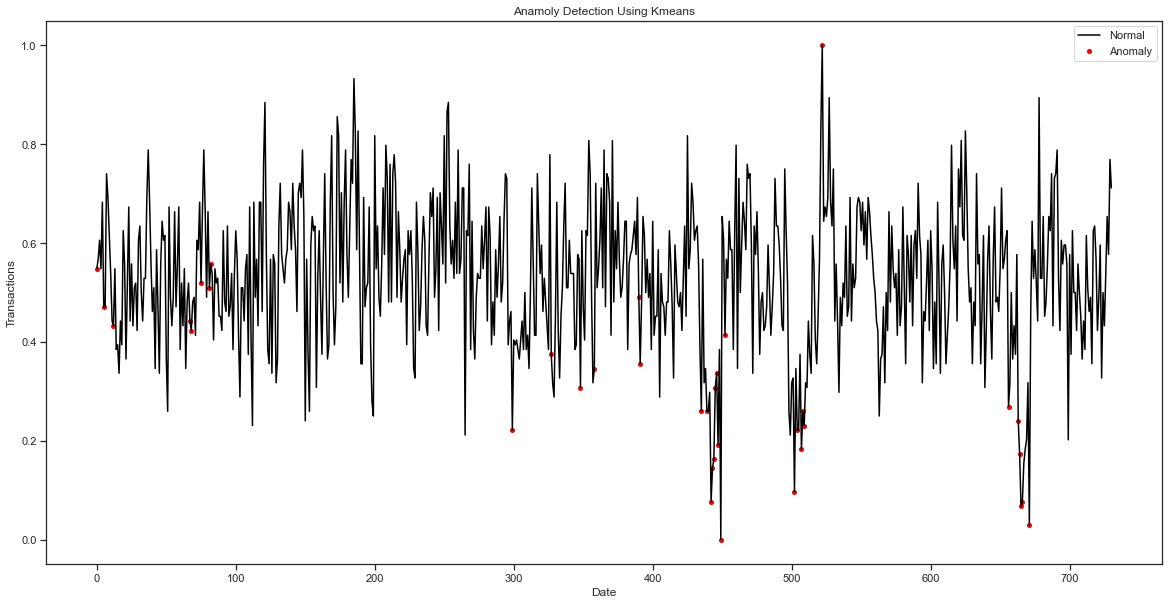

In [46]:
fig, ax = plt.subplots(figsize=(20,10))

#anomaly
a = data_.loc[data_['anomaly_kmeans'] == 1]
ax.plot(data_['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Kmeans")
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.savefig('KMeans_anomaly_Transactions.png')
plt.show();

In [47]:
final_anomaly_ = data_.query('anomaly_kmeans == 1')
final_anomaly_

,Transaction_value,block,Transactions,anomaly_kmeans
0,0.005303,0.042343,0.548077,1
5,0.011167,0.156153,0.471154,1
12,0.013473,0.216186,0.432692,1
67,0.016501,0.146011,0.442308,1
68,0.009997,0.000000,0.423077,1
75,0.011180,0.069087,0.519231,1
81,0.014120,0.166113,0.509615,1
82,0.008874,0.068362,0.557692,1
299,0.010871,0.186537,0.221154,1
327,0.016696,0.217179,0.375000,1
